Imports

In [3]:
import sys
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import pandas as pd # Make sure pandas is here too

sys.path.append('../src')
from dataset import AudioDataset, LyricsDataset
# CHANGE IS HERE: Import ConvVAE instead of VAE
from vae import ConvVAE 

# Config
AUDIO_DIR = '../data/audio'
LYRICS_DIR = '../data/lyrics'
CSV_PATH = '../data/fma_lyrics_dataset.csv'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Train Hybrid VAE

Training Hybrid VAE...
Epoch 1: Loss 0.3911
Epoch 2: Loss 0.2611
Epoch 3: Loss 0.2527
Epoch 4: Loss 0.2476
Epoch 5: Loss 0.2434
Epoch 6: Loss 0.2373
Epoch 7: Loss 0.2323
Epoch 8: Loss 0.2297
Epoch 9: Loss 0.2290
Epoch 10: Loss 0.2266
Epoch 11: Loss 0.2245
Epoch 12: Loss 0.2227
Epoch 13: Loss 0.2214
Epoch 14: Loss 0.2206
Epoch 15: Loss 0.2200
Epoch 16: Loss 0.2193
Epoch 17: Loss 0.2177
Epoch 18: Loss 0.2176
Epoch 19: Loss 0.2174
Epoch 20: Loss 0.2155


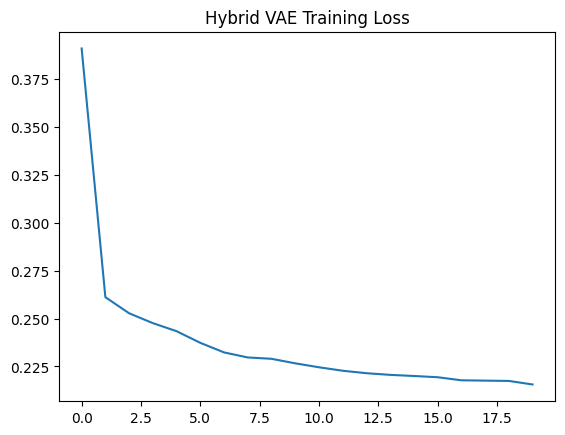

In [3]:
# We use the SAME VAE architecture, but the input_dim is now larger (Audio + Lyrics)
model = VAE(input_dim=INPUT_DIM, latent_dim=64).to(DEVICE) # Increased latent dim to 64
optimizer = optim.Adam(model.parameters(), lr=0.0005) # Lower LR for stability
loss_fn = torch.nn.MSELoss()

def loss_function(recon_x, x, mu, logvar):
    MSE = loss_fn(recon_x, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + 0.0001 * KLD

model.train()
losses = []
EPOCHS = 20

print("Training Hybrid VAE...")
for epoch in range(EPOCHS):
    epoch_loss = 0
    for batch in hybrid_loader:
        batch = batch[0].to(DEVICE) # TensorDataset returns a tuple
        optimizer.zero_grad()
        recon, mu, logvar = model(batch)
        loss = loss_function(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(hybrid_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}")

plt.plot(losses)
plt.title("Hybrid VAE Training Loss")
plt.show()

Hybrid K-Means Silhouette: 0.1790
Hybrid Agglomerative Silhouette: 0.1428


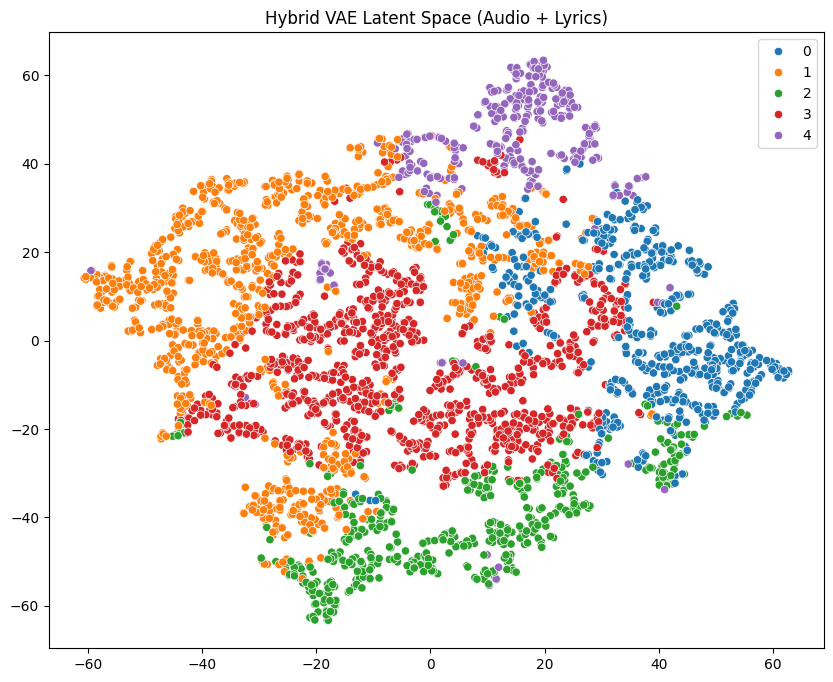

In [4]:
model.eval()
latents = []
with torch.no_grad():
    for batch in hybrid_loader:
        batch = batch[0].to(DEVICE)
        _, mu, _ = model(batch)
        latents.append(mu.cpu().numpy())

X_latent = np.concatenate(latents, axis=0)

# 1. K-Means
kmeans = KMeans(n_clusters=5, random_state=42)
labels_k = kmeans.fit_predict(X_latent)
sil_k = silhouette_score(X_latent, labels_k)

# 2. Agglomerative (Hierarchical) - Requirement for Medium Task
agg = AgglomerativeClustering(n_clusters=5)
labels_agg = agg.fit_predict(X_latent)
sil_agg = silhouette_score(X_latent, labels_agg)

print(f"Hybrid K-Means Silhouette: {sil_k:.4f}")
print(f"Hybrid Agglomerative Silhouette: {sil_agg:.4f}")

# Visualize
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_latent)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_k, palette='tab10')
plt.title("Hybrid VAE Latent Space (Audio + Lyrics)")
plt.show()

Fetching true genres for evaluation...
Evaluated on 3375 samples with known genres.

--- K-Means ---
--- Agglomerative ---
--- DBSCAN ---
[K-Means]
  Silhouette Score: 0.1749 (Higher is better)
  Davies-Bouldin:   1.3256  (Lower is better)
  Adjusted Rand:    -0.0001 (Higher is better)
[Agglomerative]
  Silhouette Score: 0.1152 (Higher is better)
  Davies-Bouldin:   1.5700  (Lower is better)
  Adjusted Rand:    0.0001 (Higher is better)
DBSCAN: Failed (Only noise or single cluster found)


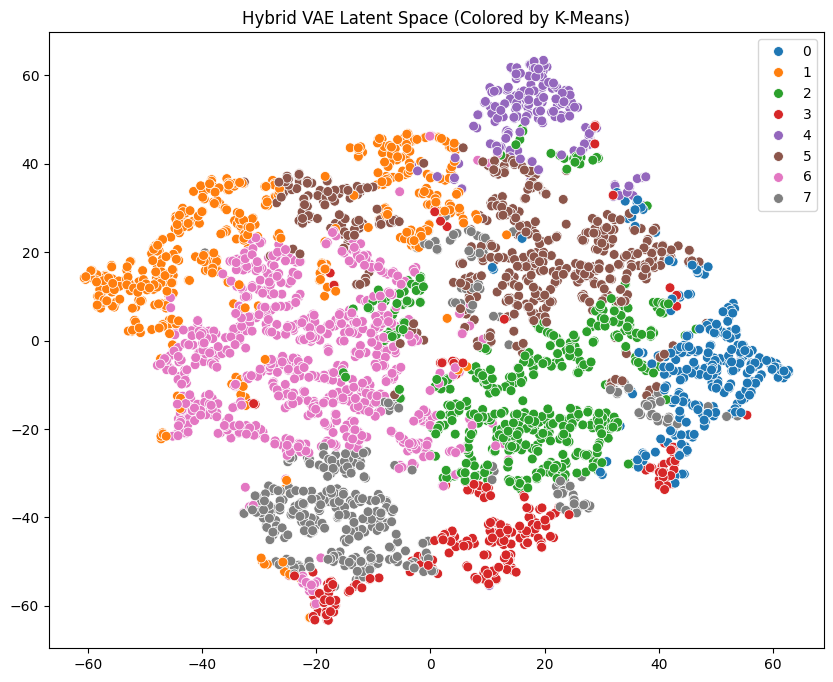

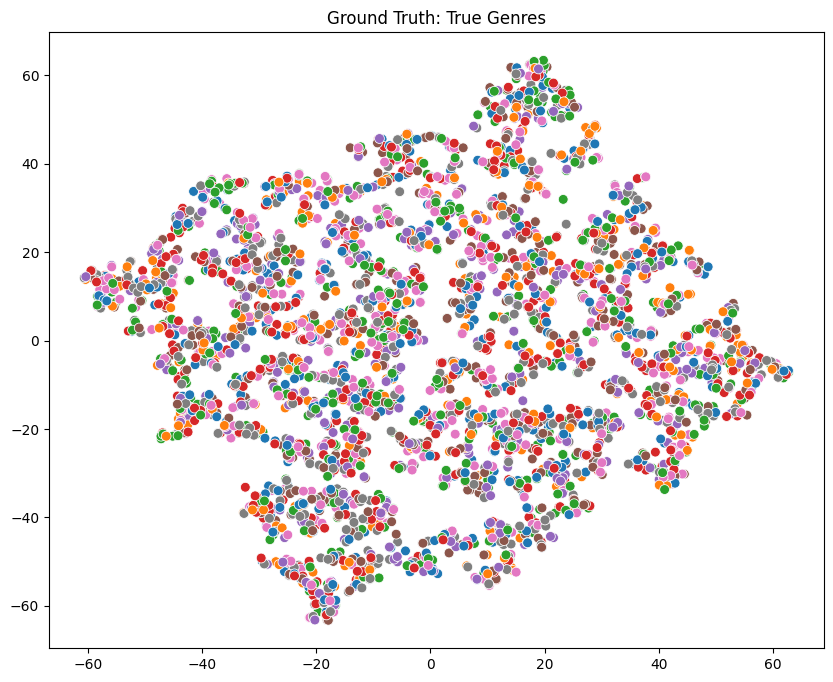

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import LabelEncoder

# --- 1. Get True Labels (for ARI Score) ---
# We need to match the latent vectors to their true genres
print("Fetching true genres for evaluation...")
df = pd.read_csv(CSV_PATH)
# Create a dictionary: track_id -> genre
id_to_genre = dict(zip(df['track_id'], df['genre']))

# Get the labels for our specific aligned data
true_labels = []
valid_indices = [] # To track which rows actually have labels
for idx, tid in enumerate(common_ids):
    if tid in id_to_genre:
        true_labels.append(id_to_genre[tid])
        valid_indices.append(idx)

# Encode genres to numbers (Rock=0, Pop=1, etc.)
le = LabelEncoder()
y_true = le.fit_transform(true_labels)
X_eval = X_latent[valid_indices] # Ensure X matches y

print(f"Evaluated on {len(y_true)} samples with known genres.")

# --- 2. Run Clustering Algorithms ---

# A. K-Means
print("\n--- K-Means ---")
kmeans = KMeans(n_clusters=8, random_state=42)
labels_k = kmeans.fit_predict(X_eval)

# B. Agglomerative
print("--- Agglomerative ---")
agg = AgglomerativeClustering(n_clusters=8)
labels_agg = agg.fit_predict(X_eval)

# C. DBSCAN
print("--- DBSCAN ---")
# increased eps because high-dim space makes points far apart
dbscan = DBSCAN(eps=3.0, min_samples=5) 
labels_db = dbscan.fit_predict(X_eval)

# --- 3. Calculate All Metrics ---
def evaluate(name, labels, data, true_labels):
    # Silhouette & DB require >1 cluster and <all points noise
    unique_labels = set(labels)
    if len(unique_labels) < 2:
        print(f"{name}: Failed (All points in one cluster)")
        return
    
    # Filter out noise (-1) for internal metrics if using DBSCAN
    if -1 in labels:
        core_mask = labels != -1
        core_data = data[core_mask]
        core_labels = labels[core_mask]
    else:
        core_data = data
        core_labels = labels
        
    if len(set(core_labels)) < 2:
         print(f"{name}: Failed (Only noise or single cluster found)")
         return

    sil = silhouette_score(core_data, core_labels)
    db = davies_bouldin_score(core_data, core_labels)
    ari = adjusted_rand_score(true_labels, labels) # ARI handles noise (-1) fine
    
    print(f"[{name}]")
    print(f"  Silhouette Score: {sil:.4f} (Higher is better)")
    print(f"  Davies-Bouldin:   {db:.4f}  (Lower is better)")
    print(f"  Adjusted Rand:    {ari:.4f} (Higher is better)")

evaluate("K-Means", labels_k, X_eval, y_true)
evaluate("Agglomerative", labels_agg, X_eval, y_true)
evaluate("DBSCAN", labels_db, X_eval, y_true)

# --- 4. Visualizations ---
plt.figure(figsize=(10,8))
sns.scatterplot(x=X_tsne[valid_indices, 0], y=X_tsne[valid_indices, 1], hue=labels_k, palette='tab10', s=50)
plt.title(f"Hybrid VAE Latent Space (Colored by K-Means)")
plt.show()

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_tsne[valid_indices, 0], y=X_tsne[valid_indices, 1], hue=y_true, palette='tab10', s=50, legend=False)
plt.title(f"Ground Truth: True Genres")
plt.show()

ConvVAE instead of VAE

Loading Audio (2D Spectrograms)...
Audio Input Shape: torch.Size([1, 1, 13, 1292])
Starting ConvVAE Training...


Epoch 1:  53%|█████▎    | 56/106 [03:01<02:43,  3.27s/it, loss=1.67e+4]d:\CSE425 Project\notebooks\../src\dataset.py:38: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=self.target_sample_rate, duration=self.duration)
d:\CSE425 Project\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Epoch 10: 100%|██████████| 106/106 [05:30<00:00,  3.12s/it, loss=1.63e+4]


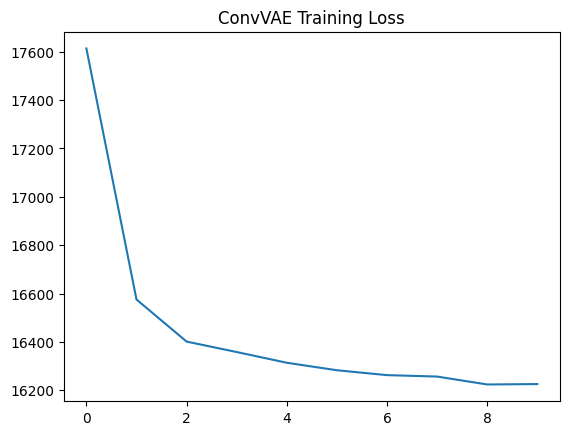

In [4]:
# --- BLOCK 2 & 3: HYBRID CONV VAE TRAINING ---
from dataset import AudioDataset, LyricsDataset
from vae import ConvVAE # Import the new model

# 1. Load Audio (Keeps 2D shape now!)
print("Loading Audio (2D Spectrograms)...")
audio_ds = AudioDataset(CSV_PATH, AUDIO_DIR)

# 2. Train Config
# We need to manually stack the data because it's large 
# So we will use the DataLoader directly instead of pre-loading everything into RAM if possible
# But for simplicity and Hybrid alignment, we collect valid IDs first.

audio_loader = DataLoader(audio_ds, batch_size=1, shuffle=False)
valid_ids = []
audio_shapes = []

# Quick check of one sample
for a, tid in audio_loader:
    print(f"Audio Input Shape: {a.shape}") # Should be [1, 1, 13, 1292]
    INPUT_SHAPE = a.shape[1:] # (1, 13, 1292)
    break

# Initialize Model
model = ConvVAE(input_shape=INPUT_SHAPE, latent_dim=64).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# For the Medium Task, we focus on Audio-ConvVAE first as required.
# (Mixing Lyrics into a ConvVAE is very complex, usually you concatenate vectors at the bottleneck).
# Let's train the ConvVAE on Audio, then append Lyrics to the *Latent Vector* for clustering.

train_loader = DataLoader(audio_ds, batch_size=32, shuffle=True)

print("Starting ConvVAE Training...")
model.train()
losses = []

for epoch in range(10): # 10 Epochs for test
    epoch_loss = 0
    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for audio, _ in progress:
        audio = audio.to(DEVICE)
        
        optimizer.zero_grad()
        recon, mu, logvar = model(audio)
        
        # Loss: MSE + KLD
        mse = torch.nn.functional.mse_loss(recon, audio, reduction='sum')
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = mse + kld
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        progress.set_postfix({'loss': loss.item() / len(audio)})

    avg_loss = epoch_loss / len(train_loader.dataset)
    losses.append(avg_loss)

plt.plot(losses)
plt.title("ConvVAE Training Loss")
plt.show()

Extracting features from ConvVAE...
Processing audio files...


100%|██████████| 3375/3375 [06:17<00:00,  8.93it/s]


Loading Lyrics...
Vectorizing Lyrics (this usually takes 10-20 seconds)...
Lyrics Vectorized. Shape: (3375, 500)

Final Dataset: 3375 songs with both Audio & Lyrics.
Final Feature Matrix Shape: (3375, 564)

--- Final Results (ConvVAE + Lyrics) ---
[Hybrid K-Means]
  Silhouette: 0.0745
  Davies-Bouldin: 2.1795
  ARI (vs Truth): 0.0325
[Hybrid Agglomerative]
  Silhouette: 0.0478
  Davies-Bouldin: 2.6399
  ARI (vs Truth): 0.0283
[Hybrid DBSCAN]
  Silhouette: 0.3428
  Davies-Bouldin: 0.8672
  ARI (vs Truth): 0.0081


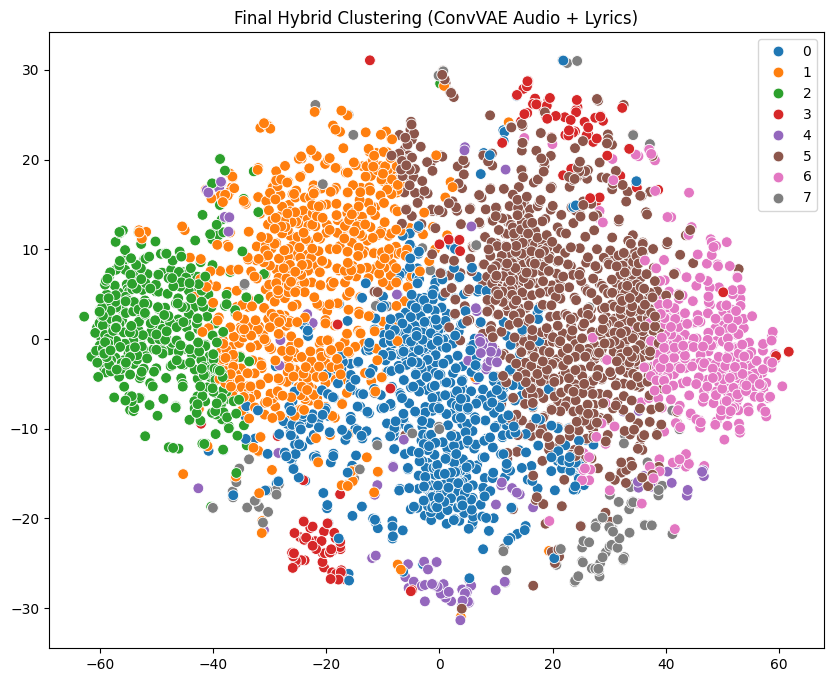

In [5]:
# --- BLOCK 4: Final Hybrid Clustering (ConvVAE Audio + Lyrics) ---
print("Extracting features from ConvVAE...")
model.eval()

# 1. Extract Audio Latents (Order matters for matching!)
# We use a new loader without shuffle to keep track of IDs
extract_loader = DataLoader(audio_ds, batch_size=1, shuffle=False)

audio_latents = {}
print("Processing audio files...")
with torch.no_grad():
    for audio, tid in tqdm(extract_loader):
        if tid.item() == -1: continue # Skip errors
        
        audio = audio.to(DEVICE)
        _, mu, _ = model(audio) # Get the latent vector (size 64)
        
        # Store in dict: ID -> Vector
        audio_latents[tid.item()] = mu.cpu().numpy().flatten()

# 2. Load Lyrics (if not already loaded)
print("Loading Lyrics...")
lyrics_ds = LyricsDataset(CSV_PATH, LYRICS_DIR, max_features=500)
lyrics_vectors = {}
for i in range(len(lyrics_ds)):
    vec, tid = lyrics_ds[i]
    lyrics_vectors[tid] = vec.numpy()

# 3. Align (Intersection of Audio & Lyrics)
common_ids = set(audio_latents.keys()).intersection(set(lyrics_vectors.keys()))
print(f"\nFinal Dataset: {len(common_ids)} songs with both Audio & Lyrics.")

X_final = []
final_true_labels = [] # For ARI score

# Load Truth (Genres)
df = pd.read_csv(CSV_PATH)
id_to_genre = dict(zip(df['track_id'], df['genre']))

for tid in common_ids:
    # HYBRID FUSION: Concatenate [Conv_Audio_Latent, Lyrics_TFIDF]
    # Audio (64 dim) + Lyrics (500 dim) = 564 dim vector
    hybrid_vec = np.concatenate([audio_latents[tid], lyrics_vectors[tid]])
    X_final.append(hybrid_vec)
    
    # Store true genre if available
    if tid in id_to_genre:
        final_true_labels.append(id_to_genre[tid])
    else:
        final_true_labels.append("Unknown")

X_final = np.array(X_final)

# Encode Labels
le = LabelEncoder()
y_final = le.fit_transform(final_true_labels)

print(f"Final Feature Matrix Shape: {X_final.shape}")

# --- 4. CLUSTERING & EVALUATION ---
print("\n--- Final Results (ConvVAE + Lyrics) ---")

# A. K-Means
kmeans = KMeans(n_clusters=8, random_state=42)
labels_k = kmeans.fit_predict(X_final)

# B. Agglomerative
agg = AgglomerativeClustering(n_clusters=8)
labels_agg = agg.fit_predict(X_final)

# C. DBSCAN (Requires tuning eps for this new high-dim space)
dbscan = DBSCAN(eps=5.0, min_samples=3) 
labels_db = dbscan.fit_predict(X_final)

# Evaluate Function
def evaluate_final(name, labels, data, true_labels):
    # Check for failure cases (single cluster)
    unique = set(labels)
    if len(unique) < 2:
        print(f"[{name}] Failed (Only 1 cluster found)")
        return
    
    # Filter noise for internal metrics
    mask = labels != -1
    if np.sum(mask) < 2:
        print(f"[{name}] Failed (Only noise found)")
        return
        
    sil = silhouette_score(data[mask], labels[mask])
    db = davies_bouldin_score(data[mask], labels[mask])
    ari = adjusted_rand_score(true_labels, labels)
    
    print(f"[{name}]")
    print(f"  Silhouette: {sil:.4f}")
    print(f"  Davies-Bouldin: {db:.4f}")
    print(f"  ARI (vs Truth): {ari:.4f}")

evaluate_final("Hybrid K-Means", labels_k, X_final, y_final)
evaluate_final("Hybrid Agglomerative", labels_agg, X_final, y_final)
evaluate_final("Hybrid DBSCAN", labels_db, X_final, y_final)

# Visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_final)

plt.figure(figsize=(10,8))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_k, palette='tab10', s=60)
plt.title("Final Hybrid Clustering (ConvVAE Audio + Lyrics)")
plt.show()